In [1]:
#import the module in the parent folder
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
import mylib
from mylib.dataloading import *
from mylib import utilities

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib.patches as mpatches
import plotly.express as px
import numpy as np
from kneed import KneeLocator
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

np.random.seed(10)

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
plt.style.use('seaborn')
params = {
    'figure.figsize': (15, 5),
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'axes.titlesize': 'x-large',
}
plt.rcParams.update(params)

In [5]:
indicators = ["I", "Iu", "Imax", "Imin", "E", "Recency", "Frequency", "MonetaryValue", "FirstPurchase"]

In [6]:
print(CUSTOMER_PROFILE_DATASET_NAME)
df = load_customer_data(CUSTOMER_PROFILE_DATASET_NAME)
df.info()
df_prv = df.copy()

customer_profile.csv
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3752 entries, 0 to 3754
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     3752 non-null   int64  
 1   Country        3752 non-null   object 
 2   I              3752 non-null   int64  
 3   Iu             3752 non-null   int64  
 4   Imax           3752 non-null   int64  
 5   Imin           3752 non-null   int64  
 6   E              3752 non-null   float64
 7   MBP            3752 non-null   object 
 8   Recency        3752 non-null   int64  
 9   Frequency      3752 non-null   int64  
 10  MonetaryValue  3752 non-null   float64
 11  FirstPurchase  3752 non-null   int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 381.1+ KB


Considering the correlation matrix shown in *Data preparation* phase, we decided to delete highly correlated attributes to apply clustering algorithms.
In particular we remove the total number of items purchased by a customer (I) and the number of distinct items purchased by a customer (Iu) indicators. Indeed they have an high correlation coefficient with both frequency and monetary value indicators.

In [7]:
# remove I, Iu
indicators = ["Imax", "Imin", "E", "Recency", "Frequency", "MonetaryValue", "FirstPurchase"]

We select the columns of interest

In [8]:
data = df[indicators]

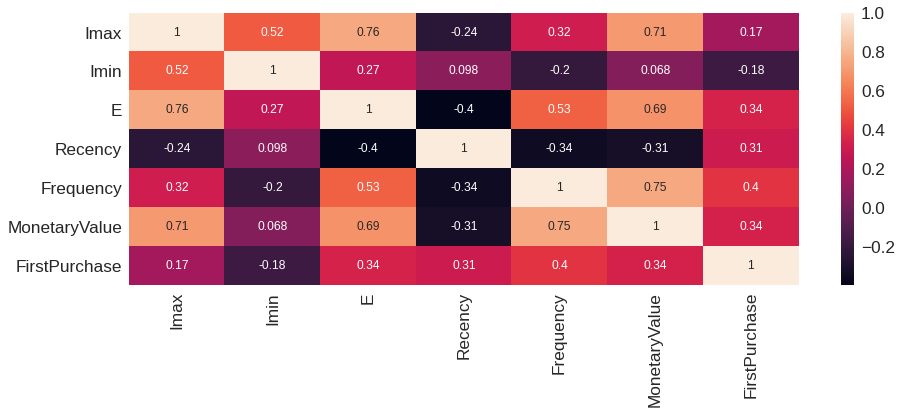

In [9]:
corrMatrix = data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()
#plt.savefig("../fig/corrmatrix_nocorr.png")

## Dimensionality reduction with PCA
First of all we want to reduce the dimensionality of the indicators. We decided to use *Principal Component Analysis*. <br>
We need to decide how many features we'd like to keep.

In [10]:
# Data normalization
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [11]:
pca = PCA()
pca.fit_transform(scaled_data)

array([[ 0.3676211 ,  0.55135066,  0.03047064, ...,  0.10730542,
        -0.08604801, -0.00100392],
       [-0.51083549,  0.22102921,  0.31172516, ...,  0.09212136,
         0.06608116,  0.00089448],
       [ 0.42187639, -0.4352646 ,  0.17975494, ...,  0.01813982,
         0.0172268 ,  0.00360695],
       ...,
       [-0.33369922,  0.07018349, -0.10651387, ..., -0.0141172 ,
         0.00722202, -0.01272896],
       [-0.18909911,  0.16040638, -0.11028743, ..., -0.01674445,
         0.00669987,  0.01161011],
       [-0.05319114,  0.13728381,  0.04327368, ...,  0.00354381,
         0.00682152, -0.01059017]])

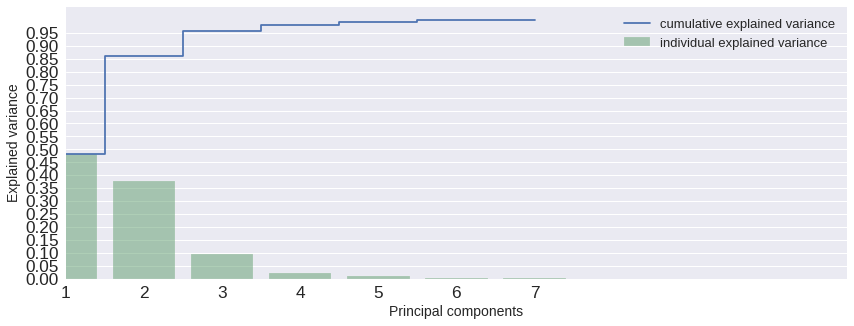

In [12]:
fig, ax = plt.subplots(figsize=(14, 5))
plt.step(range(scaled_data.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1, scaled_data.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticks(range(0, 11))
ax.set_yticks(np.arange(0.0, 1.0, 0.05))

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13)
plt.show()
#plt.savefig("../fig/cumulative_individual_explained_var.png")

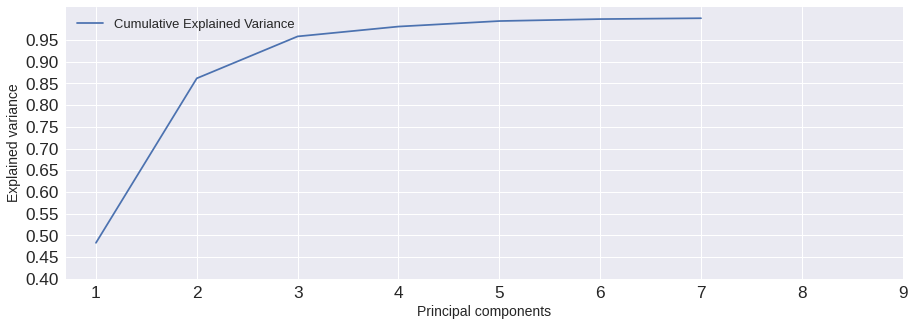

In [13]:
plt.plot(range(1, scaled_data.shape[1]+1), pca.explained_variance_ratio_.cumsum(), label='Cumulative Explained Variance')
plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13)
plt.xticks(range(1, 10))
plt.yticks(np.arange(0.4, 1.0, 0.05))
plt.show()
#plt.savefig("../fig/cumulative_explained_var.png")

The plots shows the amount of variance captured (on the y-axis) depending on the number of components we included (the x-axis). In this instance, we decide to keep 3 components. In this way we preserve more than the $90$% of the variance.

In [14]:
n_components = 3

Then we create a pipeline that takes the raw customer dataset as input and apply standardization and dimensionality reduction. 

In [15]:
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()), 
        ("pca", PCA(n_components=n_components)),
    ]
)

In [16]:
preprocessor.fit(data)
preproc_data = preprocessor.transform(data)

In [17]:
preproc_data.shape

(3752, 3)

## Density-based Clustering

Analysis by density-based clustering:  
1. Study of the clustering parameters
2. Characterization and interpretation of the obtained clusters

In order to choose the value of the minimum number of points *(minPts or minSamples)* we used the method described by *Sander et al.*:
$minPts = 2 * dim$

In [18]:
min_pts = preproc_data.shape[1] * 2
print("Min_pts: ", min_pts)

Min_pts:  6


Now we can determine $\epsilon$. We calculate the average distance between each point and its $k$ nearest neighbors, where $k = minPts$ and we plot them.

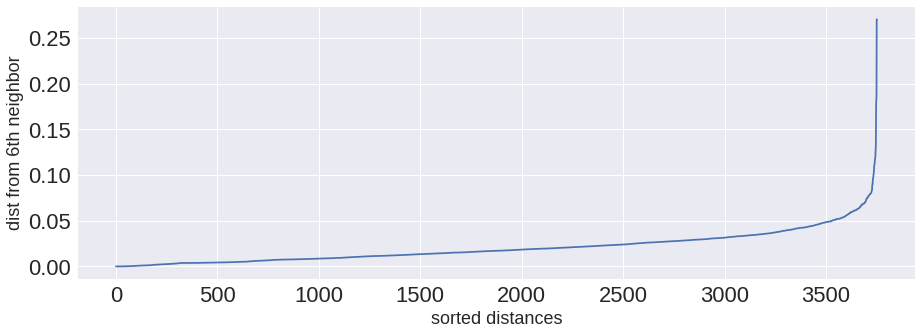

In [19]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=min_pts)
neighbors_fit = neighbors.fit(preproc_data)
distances, indices = neighbors_fit.kneighbors(preproc_data)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.ylabel(f'dist from {min_pts}th neighbor', fontsize=18)
plt.xlabel('sorted distances', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.plot(distances)
plt.show()
#plt.savefig("../fig/distances_DBSCAN.png")

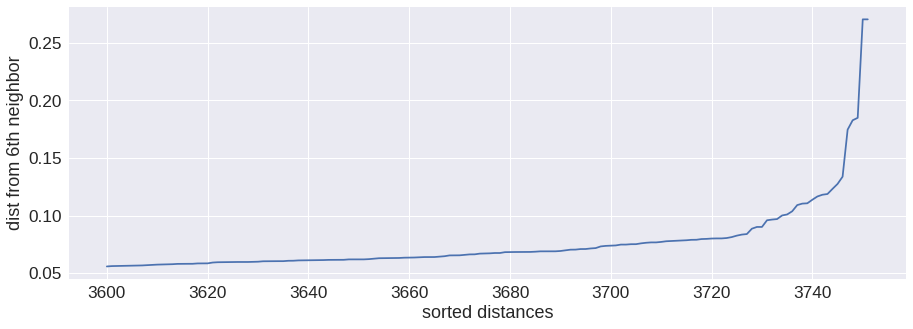

In [20]:
zoom_from = 3600
plt.ylabel(f'dist from {min_pts}th neighbor', fontsize=18)
plt.xlabel('sorted distances', fontsize=18)
#plt.yticks(np.arange(0.0, 1, 0.05))
plt.plot(range(zoom_from, len(distances)), distances[zoom_from:])

We choose as optimal value for the parameter $\epsilon$ the point of maximum curvature. <br>

In [21]:
dbscan = DBSCAN(eps=0.14, min_samples=min_pts)
dbscan.fit(preproc_data)
np.unique(dbscan.labels_)
display(pd.Series(dbscan.labels_).value_counts())

 0    3740
-1      12
dtype: int64

Now we could apply the *DBSCAN* algorithm but there is a few number of outliers. Considering that we want to use DBSCAN to find outliers, we decided to explore different *DBSCAN* parameters values. 

In [22]:
for eps in [0.13, 0.12, 0.11, 0.1, 0.09, 0.008]:
    dbscan = DBSCAN(eps=eps, min_samples=min_pts)
    dbscan.fit(preproc_data)
    np.unique(dbscan.labels_)
    print("eps: ", eps)
    display(pd.Series(dbscan.labels_).value_counts())

eps:  0.13


 0    3737
-1      15
dtype: int64

eps:  0.12


 0    3730
-1      22
dtype: int64

eps:  0.11


 0    3714
-1      38
dtype: int64

eps:  0.1


 0    3342
 1     360
-1      50
dtype: int64

eps:  0.09


 0    3315
 1     360
-1      77
dtype: int64

eps:  0.008


-1     3508
 15      24
 3       14
 8       13
 11      12
 9       10
 14       9
 16       9
 13       9
 6        9
 22       8
 25       8
 0        8
 12       8
 17       8
 2        8
 21       8
 5        8
 20       7
 18       7
 23       7
 4        6
 10       6
 27       6
 24       6
 26       6
 1        6
 7        5
 19       5
 28       4
dtype: int64

In [23]:
dbscan = DBSCAN(eps=0.1, min_samples=min_pts)
dbscan.fit(preproc_data)
np.unique(dbscan.labels_)
display(pd.Series(dbscan.labels_).value_counts())

 0    3342
 1     360
-1      50
dtype: int64

In [24]:
dict_color = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', -1:'black'}
label_color = [dict_color[l] for l in dbscan.labels_]

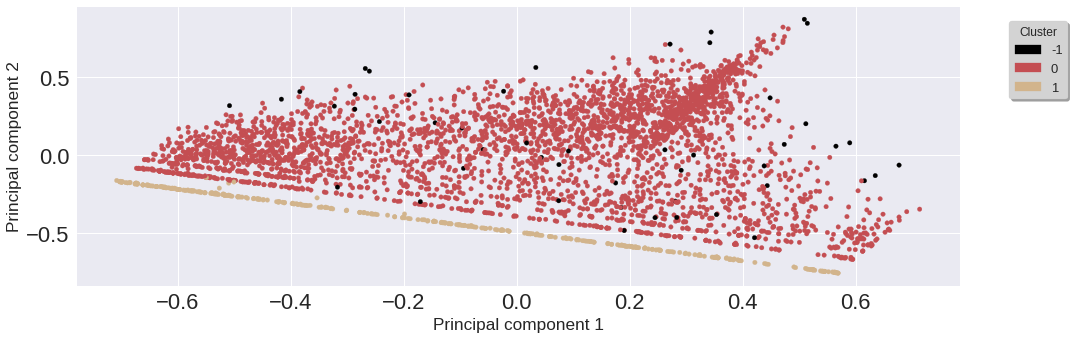

In [25]:
plt.scatter(preproc_data[:, 0], preproc_data[:, 1], c=label_color, s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
comp_handler = []
for i in np.unique(dbscan.labels_):
    comp_handler.append(mpatches.Patch(color = dict_color[i], label = i))

plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
    
plt.legend(handles=comp_handler, bbox_to_anchor=(1.0, 0.92), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()
plt.show()

### Outlier detection with DBSCAN 

Observing the plot above it is easy to see that there are a lot of outliers. After a discussion we decided to delete these outliers using the results obtained by *DBSCAN*. 

In [26]:
df = df[dbscan.labels_ != -1]

Then we repeat the normalization process on new data.

In [27]:
data = df[indicators]
# Data normalization
preprocessor.fit(data)
preproc_data_new = preprocessor.transform(data)

## KMeans

Clustering Analysis by K-means:  
1. Identification of the best value of k
2. Characterization of the obtained clusters by using both analysis of the k centroids and comparison of the distribution of variables within the clusters and that in the whole dataset
3. Evaluation of the clustering results

In [28]:
range_nclusters = range(1, 11)

In [29]:
wcss, models = utilities.run_kmeans(preproc_data_new, range_nclusters)

In [30]:
for m in models[1:]:
    utilities.print_metrics(preproc_data_new, m)

K=2
	SSE:		580.1308512392402
	Silhouette:		0.3567266814204659
	DaviesBouldin score:		1.1124167128571139
K=3
	SSE:		324.8371672098508
	Silhouette:		0.4537610395580464
	DaviesBouldin score:		0.8046227246831276
K=4
	SSE:		277.6646513743251
	Silhouette:		0.36213504612543584
	DaviesBouldin score:		1.0260405117902582
K=5
	SSE:		233.10778823809363
	Silhouette:		0.32859240058901773
	DaviesBouldin score:		1.0754309170310203
K=6
	SSE:		199.85374257265227
	Silhouette:		0.31691690302946335
	DaviesBouldin score:		1.0786366754099956
K=7
	SSE:		179.3961786762266
	Silhouette:		0.3185079412647424
	DaviesBouldin score:		1.0752647814867402
K=8
	SSE:		160.12468293043125
	Silhouette:		0.31510600937102856
	DaviesBouldin score:		1.0524360633735248
K=9
	SSE:		147.3560141804566
	Silhouette:		0.3057794157852722
	DaviesBouldin score:		1.0790584442672526
K=10
	SSE:		136.13487758833062
	Silhouette:		0.3037577826154609
	DaviesBouldin score:		1.0647423373070255


We used the `kneed` library to programmatically compute the elbow point.

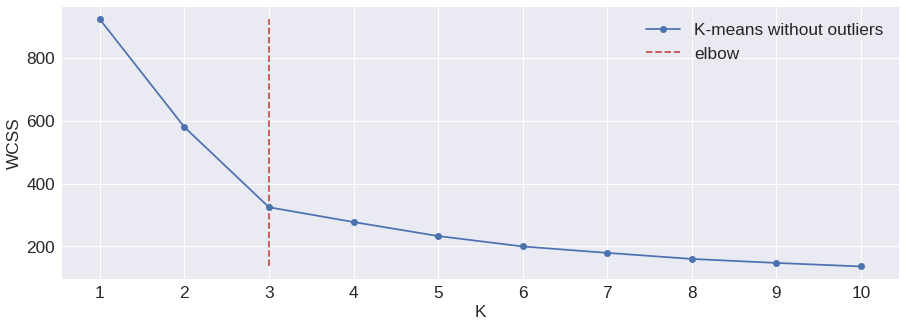

In [31]:
kl = KneeLocator(range_nclusters, wcss, curve="convex", direction="decreasing")
plt.plot(range_nclusters, wcss, 'o-', label="K-means without outliers")
plt.vlines(kl.elbow, min(wcss), max(wcss), 'r', '--', label="elbow")
plt.xticks(range_nclusters)
plt.xlabel("K")
plt.ylabel("WCSS")
plt.legend()
plt.show()
#plt.savefig("../fig/elbow.png")

The first plot shows the *Within Clusters Sum of Square*. We apply the elbow method and obtain 3 as best $K$ value. Then we decided to use a more robust method. This method is based on the silhouette score.

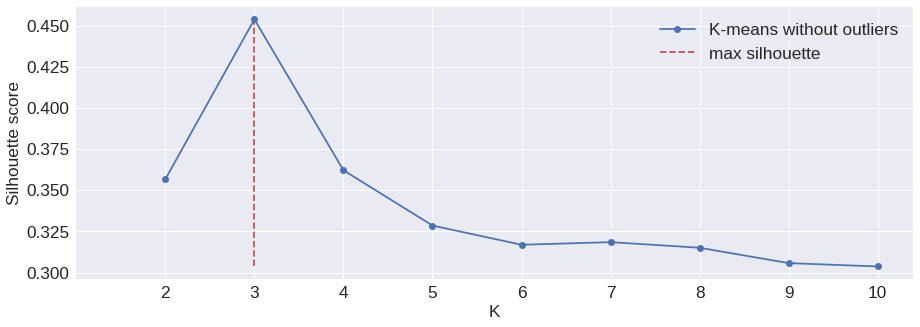

In [32]:
sil_score = []
for m in models[1:]:
    sil_score.append(metrics.silhouette_score(preproc_data_new, m.labels_))
    
plt.plot(range(2, 11), sil_score, 'bo-', label="K-means without outliers")
plt.vlines(np.argmax(sil_score) + 2, min(sil_score), max(sil_score), 'r', '--', label="max silhouette")
plt.xticks(range_nclusters)
plt.xlabel("K")
plt.xticks(range(2, 11))
plt.ylabel("Silhouette score")
plt.legend()
plt.show()
#plt.savefig("../fig/silhouette.png")

The second plot shows the silhouette score for each $K$. Considering that we obtained the same result, we decided to use a 3-cluster solutions.

In [33]:
n_clusters = kl.elbow
best_run = n_clusters - 1
kmeans_model = models[best_run]
cluster_labels = kmeans_model.predict(preproc_data_new)

In [34]:
mat = pd.DataFrame(preproc_data_new.copy())
mat['Cluster'] = pd.Series(cluster_labels)

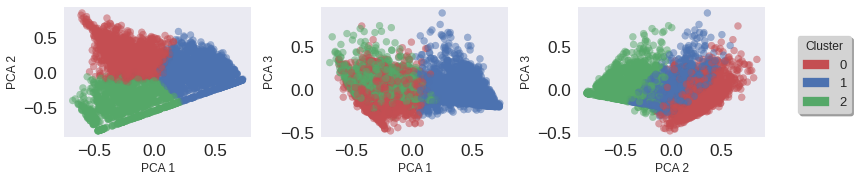

In [35]:
dict_color = {0:'r', 1:'b', 2:'g', 3: 'orange', 4: 'pink', 5:'brown'}

label_color = [dict_color[c] for c in mat['Cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(3):
    for iy in range(ix+1, 3):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = dict_color[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.0, 0.92), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()
plt.show()

In [36]:
df["Cluster"] = kmeans_model.labels_
display(df.head())

CustomerID      Country    I  Iu  Imax  Imin         E    MBP  Recency  \
0       12347  ['Iceland']  542  43   200    18  5.176319  22727        1   
1       12349    ['Italy']  124  19   124   124  4.247928  23439       18   
2       12350   ['Norway']   54   5    54    54  2.321928  20615      309   
3       12352   ['Norway']  131  17    35    12  3.936180  22413       35   
4       12353  ['Bahrain']    6   1     6     6  0.000000  37450      203   

   Frequency  MonetaryValue  FirstPurchase  Cluster  
0          7        1742.36            366        0  
1          1         345.92             18        1  
2          1         118.50            309        2  
3          6         395.83            296        0  
4          1          17.70            203        2

In [37]:
import plotly.graph_objects as go

plot = go.Figure()

for c in list(df.Cluster.unique()):
    
    plot.add_trace(go.Scatter3d(x = preproc_data_new[df.Cluster == c][:, 0],
                                y = preproc_data_new[df.Cluster == c][:, 1],
                                z = preproc_data_new[df.Cluster == c][:, 2],
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'Cluster_' + str(c)))
plot.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = '1° pca component', titlefont_color = 'black'),
                                yaxis=dict(title = '2° pca component', titlefont_color = 'black'),
                                zaxis=dict(title = '3° pca component', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

In [38]:
n_customer_clusters = pd.DataFrame(df["Cluster"].value_counts())
n_customer_clusters.columns = ["# customers"]
display(n_customer_clusters.T)

0     1    2
# customers  1438  1354  910

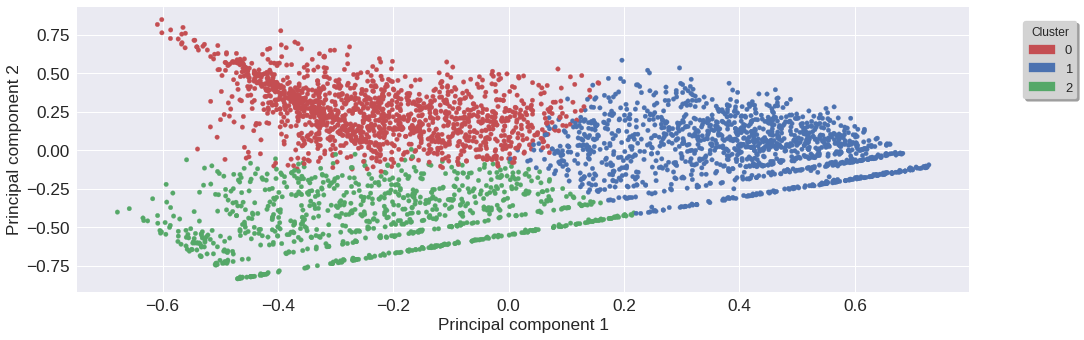

In [39]:
plt.scatter(preproc_data_new[:, 0], preproc_data_new[:, 1], c=label_color, s=20)

plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
    
plt.legend(handles=comp_handler, bbox_to_anchor=(1.0, 0.92), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)
plt.tight_layout()
plt.show()

## Hierarchical Clustering

1. Compare different clustering results got by using different version of the algorithm
2. Show and discuss different dendrograms using different algorithms

In [40]:
from scipy.stats import mode
from scipy.spatial.distance import pdist # Pairwise distances between observations in n-dimensional space.
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering 

In [41]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

The single link technique is good at handling non-elliptical shapes, but is sensitive to noise and outliers.

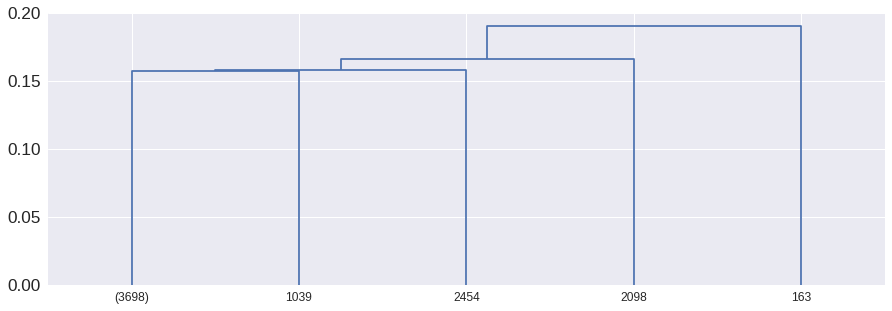

In [42]:
single = AgglomerativeClustering(linkage='single', distance_threshold=0, n_clusters=None).fit(preproc_data_new)
plot_dendrogram(single, truncate_mode='level', p=3)

In Ward agglomerative hierarchical clustering procedure, the criterion for choosing the pair of clusters to merge at each step is based on the optimal value of an objective function. We used the default objective functions (eucledian distance).

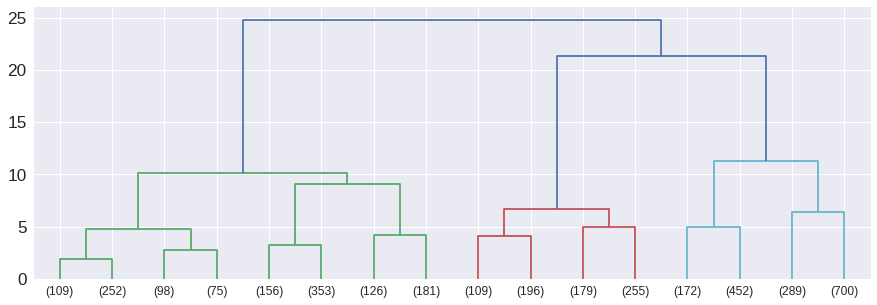

In [43]:
ward = AgglomerativeClustering(linkage='ward', distance_threshold=0, n_clusters=None).fit(preproc_data_new)
plot_dendrogram(ward, truncate_mode='level', p=3)

Complete or maximimum linkage is less susceptible to noise and outliers, but it can break large clusters and it favours globular shapes

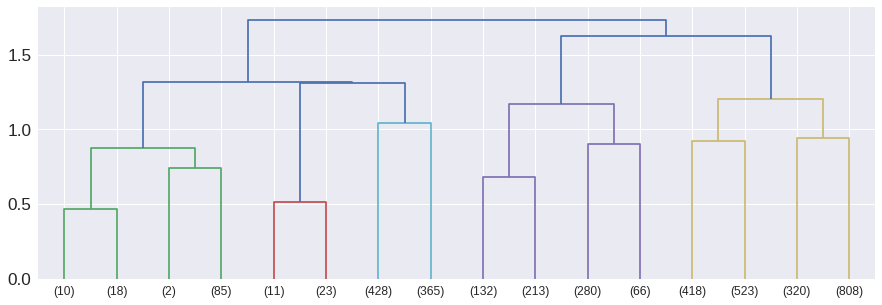

In [44]:
complete = AgglomerativeClustering(linkage='complete', distance_threshold=0, n_clusters=None).fit(preproc_data_new)
plot_dendrogram(complete, truncate_mode='level', p=3)

Average linkage is an intermediate approach between the single and complete link approaches.

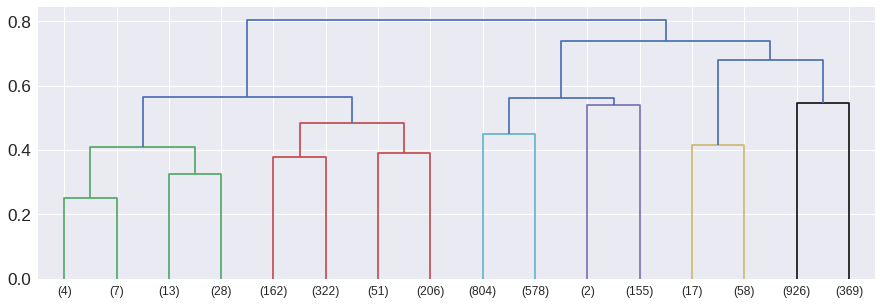

In [45]:
average = AgglomerativeClustering(linkage='average', distance_threshold=0, n_clusters=None).fit(preproc_data_new)
plot_dendrogram(average, truncate_mode='level', p=3)

It is interested to note that more the distance of the vertical lines in the dendrogram, more the distance between these clusters. <br>
We choose the ward linkage as best hierarchical clustering. Observing the dendogram of Ward linkage, you can see that it has the longest vertical line.   
Now, we can set a threshold distance in order to choose the best number of clusters. We tried to set the threshold in such a way that it cuts the tallest vertical line. The number of vertical lines this newly created horizontal line passes is equal to the optimal number of clusters. 

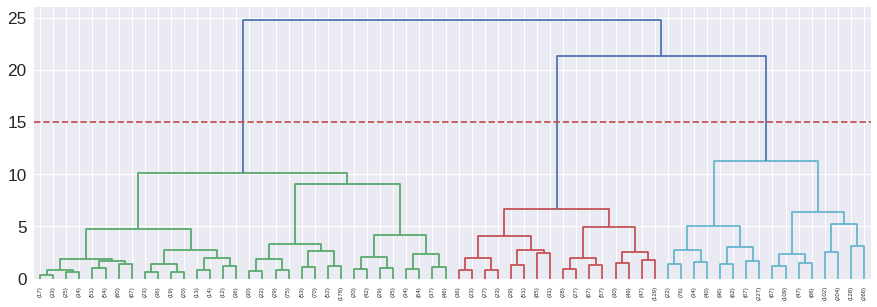

In [46]:
plot_dendrogram(ward, truncate_mode='level', p=5)
plt.axhline(c='r',linestyle='--', y=15) 
plt.show()

Therefore we decided to consider a 3-cluster solution

In [47]:
ward_best = AgglomerativeClustering(linkage='ward', n_clusters=3).fit(preproc_data_new)
label = ward_best.labels_

In [48]:
label_color_ward = [dict_color[c] for c in label]

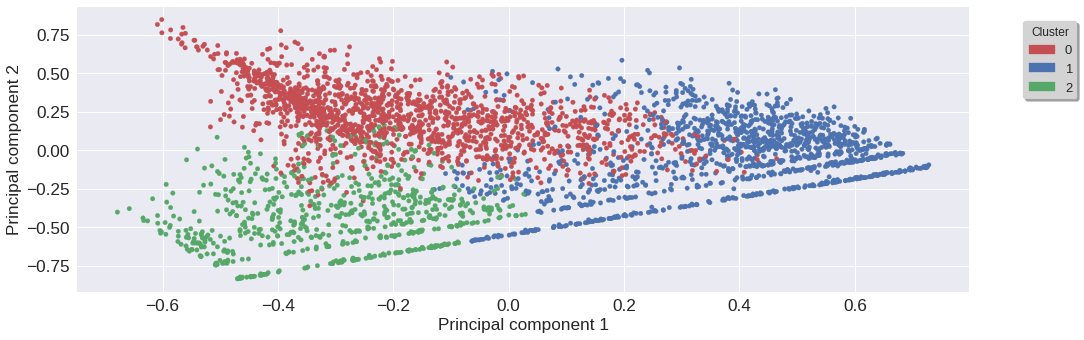

In [49]:
plt.scatter(preproc_data_new[:, 0], preproc_data_new[:, 1], c=label_color_ward, s=20)

plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
    
plt.legend(handles=comp_handler, bbox_to_anchor=(1.0, 0.92), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)
plt.tight_layout()
plt.show()

## X-MEANS

Total WCE:  90.97785467516239
Number of clusters:  20


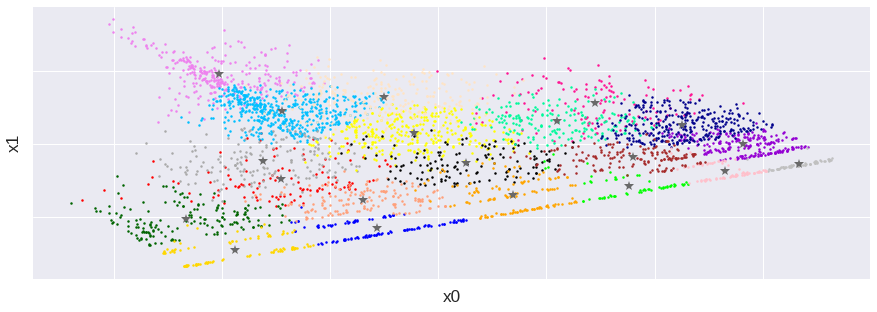

In [50]:
from pyclustering.cluster import cluster_visualizer_multidim
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

amount_initial_centers = 2
kmax= 20

initial_centers = kmeans_plusplus_initializer(preproc_data_new.tolist(), amount_initial_centers).initialize()

xmeans_instance = xmeans(preproc_data_new.tolist(), initial_centers, kmax)
xmeans_instance.process()
# clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()

# Print total sum of metric errors
print("Total WCE: ", xmeans_instance.get_total_wce())
print("Number of clusters: ", len(clusters))
# Visualize clustering results
visualizer = cluster_visualizer_multidim()
visualizer.append_clusters(clusters, preproc_data_new.tolist())
visualizer.append_cluster(centers, None, marker='*', markersize=10)
visualizer.show(pair_filter=[[0, 1]])

Different runs of **X-means** produce different results. We observed that the number of clusters vary from 3 to 20. So we decided to run this algorithm $100$ times, then we saved the results obtained.

In [51]:
n_clusters_x = []
for i in range(100):
    amount_initial_centers = 2
    kmax = 20

    initial_centers = kmeans_plusplus_initializer(preproc_data_new.tolist(), amount_initial_centers).initialize()
    xmeans_instance = xmeans(preproc_data_new.tolist(), initial_centers, kmax)
    xmeans_instance.process()
    # clusters and their centers
    clusters_x = xmeans_instance.get_clusters()
    n_clusters_x.append(len(clusters_x))

In [52]:
n_unique_clusters = set(n_clusters_x)
prob_occurrences = dict()
prob_occurrences = {k: n_clusters_x.count(k) / len(n_clusters_x) for k in n_unique_clusters}

Here we reported the results of this experiments. Left column indicates the clusters number while the right one defines the occurrence probability.

In [53]:
print("{:^10} :: {:^10}".format("#clusters", "Probability"))
for key in sorted(prob_occurrences.keys()) :
    print("{:^10} :: {:^10}".format(key, prob_occurrences[key]))

#clusters  :: Probability
    3      ::    0.29   
    4      ::    0.14   
    5      ::    0.15   
    6      ::    0.07   
    7      ::    0.04   
    8      ::    0.08   
    9      ::    0.01   
    10     ::    0.1    
    12     ::    0.02   
    15     ::    0.01   
    16     ::    0.01   
    17     ::    0.01   
    19     ::    0.01   
    20     ::    0.06   


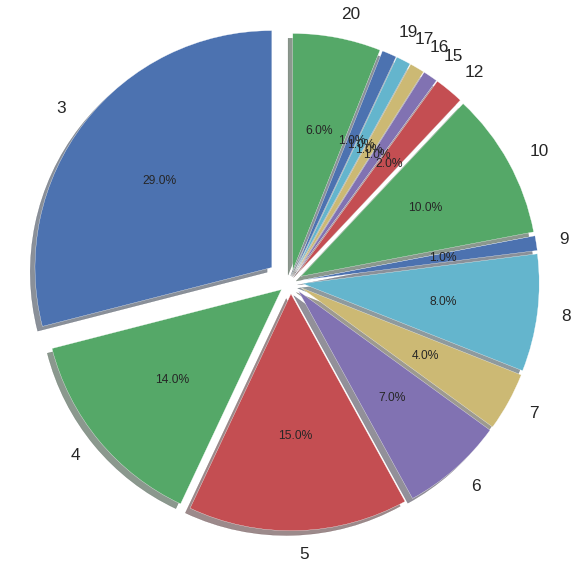

In [54]:
explode = [0.05] * len(n_unique_clusters)
explode[list(prob_occurrences.keys()).index(sorted(prob_occurrences.keys())[0])] = 0.1

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.pie(prob_occurrences.values(), explode=explode, labels=prob_occurrences.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90, normalize=False)
# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

plt.show()

In [55]:
print("(Most of the time) X-means defines %d clusters" % sorted(prob_occurrences.keys())[0])

(Most of the time) X-means defines 3 clusters


# Cluster validation

In [56]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

Text(0.5, 0.98, 'Silhouette analysis for KMeans with n_clusters = 3')

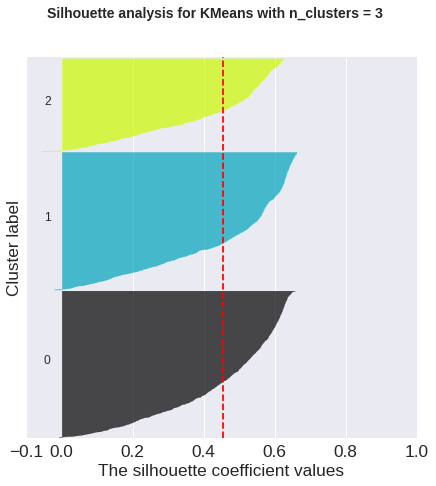

In [57]:
fig, ax1= plt.subplots(1, 1)
fig.set_size_inches(7, 7)

### FIRST PLOT ####

ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(preproc_data_new) + (n_clusters + 1) * 10])
silhouette_avg = silhouette_score(preproc_data_new, cluster_labels)
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(preproc_data_new, cluster_labels)
y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
#ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(("Silhouette analysis for KMeans "
              "with n_clusters = %d" % n_clusters),
             fontsize=14, fontweight='bold')


## Comparison between Kmeans with and without outliers

Here we want to show the difference between the results of K-means applied with and without the outliers removal.
**X** is a subset of **X_prv** in which we deleted the outliers using the DBSCAN algorithm. <br>
First of all we compute the best K value for the original customer indicators.

In [58]:
range_nclusters = range(1, 11)
wcss_prv, models_prv = utilities.run_kmeans(preproc_data, range_nclusters)
for m in models_prv[1:]:
    utilities.print_metrics(preproc_data, m)

K=2
	SSE:		538.4067973711631
	Silhouette:		0.37037066974004484
	DaviesBouldin score:		1.0649458963540734
K=3
	SSE:		290.3221175845069
	Silhouette:		0.46913292584830985
	DaviesBouldin score:		0.7741632821053009
K=4
	SSE:		248.88143478875418
	Silhouette:		0.3799862050563592
	DaviesBouldin score:		1.0243040360629632
K=5
	SSE:		211.42775459599451
	Silhouette:		0.3289301891393471
	DaviesBouldin score:		1.090889524973312
K=6
	SSE:		177.6523661908124
	Silhouette:		0.32001176545595833
	DaviesBouldin score:		1.075595251631908
K=7
	SSE:		159.3954296537275
	Silhouette:		0.31718731456812044
	DaviesBouldin score:		1.0531702158805312
K=8
	SSE:		141.73995915374712
	Silhouette:		0.31927174080222026
	DaviesBouldin score:		1.0378273666333826
K=9
	SSE:		130.78092790618135
	Silhouette:		0.3203855073558408
	DaviesBouldin score:		1.0192539623999795
K=10
	SSE:		120.68230801540335
	Silhouette:		0.3144289115068487
	DaviesBouldin score:		0.9843305856282679


3


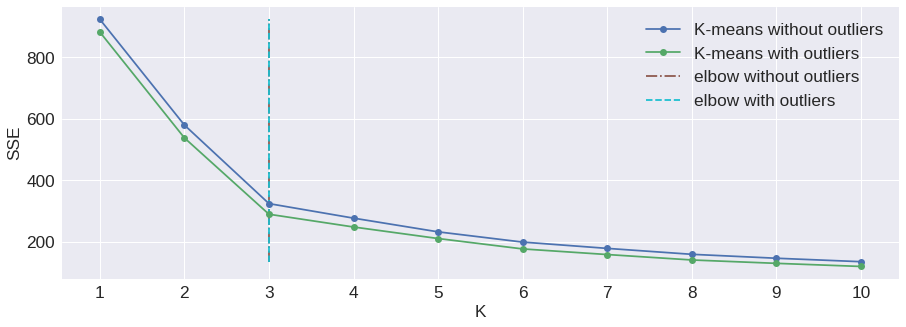

In [59]:
kl_prv = KneeLocator(range(1, 11), wcss_prv, curve="convex", direction="decreasing")
print(kl_prv.elbow)

plt.plot(range_nclusters, wcss, 'o-', label="K-means without outliers")
plt.plot(range_nclusters, wcss_prv, 'o-', label="K-means with outliers")
plt.vlines(kl.elbow, min(wcss), max(wcss), 'tab:brown', '-.', label="elbow without outliers")
plt.vlines(kl_prv.elbow, min(wcss), max(wcss), 'tab:cyan', '--', label="elbow with outliers")
plt.xticks(range_nclusters)
plt.xlabel("K")
plt.ylabel("SSE")
plt.legend()

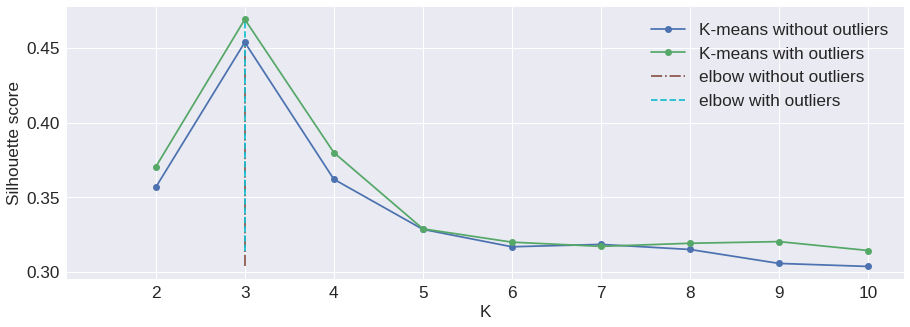

In [60]:
sil_score_prv = []
for m in models_prv[1:]:
    sil_score_prv.append(metrics.silhouette_score(preproc_data, m.labels_))
    
plt.plot(range(2, 11), sil_score, 'o-', label="K-means without outliers")
plt.plot(range(2, 11), sil_score_prv, 'o-', label="K-means with outliers")
plt.vlines(np.argmax(sil_score) + 2 , min(sil_score), max(sil_score), 'tab:brown', '-.', label="elbow without outliers")
plt.vlines(np.argmax(sil_score_prv) + 2 , min(sil_score_prv), max(sil_score_prv), 'tab:cyan', '--', label="elbow with outliers")
plt.xticks(range_nclusters)
plt.xlabel("K")
plt.xticks(range(2, 11))
plt.ylabel("Silhouette score")
plt.legend()
plt.show()

Both the SSE and silhouette are better in the version with the outliers. But we are interested in the clusters assignment distribution. Therefore, we decided to use a silhouette-based method for cluster validation

In [61]:
n_clusters_prv = kl_prv.elbow
best_run_prv = n_clusters_prv - 1
kmeans_model_prv = models_prv[best_run_prv]
cluster_labels_prv = kmeans_model.predict(preproc_data)

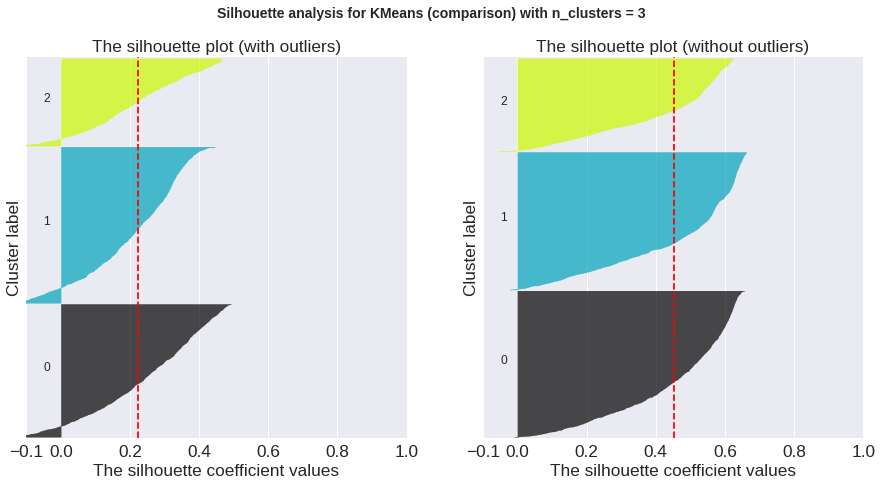

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 7)

plt.suptitle(("Silhouette analysis for KMeans (comparison) "
              "with n_clusters = %d" % n_clusters),
             fontsize=14, fontweight='bold')

### FIRST PLOT ####

ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(preproc_data) + (n_clusters + 1) * 10])
silhouette_avg = silhouette_score(preproc_data, cluster_labels_prv)
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(preproc_data, cluster_labels_prv)
y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels_prv == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
ax1.set_title("The silhouette plot (with outliers)")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


### SECOND PLOT ####

ax2.set_xlim([-0.1, 1])
ax2.set_ylim([0, len(preproc_data_new) + (n_clusters + 1) * 10])
silhouette_avg = silhouette_score(preproc_data_new, cluster_labels)
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(preproc_data_new, cluster_labels)
y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax2.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
ax2.set_title("The silhouette plot (without outliers)")
ax2.set_xlabel("The silhouette coefficient values")
ax2.set_ylabel("Cluster label")
# The vertical line for average silhouette score of all the values
ax2.axvline(x=silhouette_avg, color="red", linestyle="--")

ax2.set_yticks([])  # Clear the yaxis labels / ticks
ax2.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

The removal of outliers entails a clear change in the thickness of the silhouettes. Left plot shows negative silhouette scores for all clusters. Instead, right plot shows that all clusters silhouettes are a very similiar tickness and there are a small number of negative silhouette score. Furthermore, they are over the *overall average silhouette width*. For these reasons we chose the K-means model (without outliers version) as best clustering approach.

### Exploration of clustering results

In [63]:
df_mean_clusters = df.groupby(["Cluster"]).mean().reset_index()
df_mean_clusters = df_mean_clusters[indicators]
df_mean_clusters.head()

Imax       Imin         E     Recency  Frequency  MonetaryValue  \
0  72.827538  17.467316  4.020768   38.035466   6.253825     663.902921   
1  37.878877  26.706795  2.202381   49.579025   1.706056     150.196093   
2  29.775824  24.778022  1.808934  252.160440   1.426374     103.465824   

   FirstPurchase  
0     304.367177  
1      80.709749  
2     279.184615

In [64]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=3)


fig.add_trace(
        go.Scatterpolargl(
            r=df_mean_clusters.iloc[0], 
            theta=indicators,
            marker=dict(color="red"),
            fill='toself',
            name="Cluster 0"
        )
    )
fig.add_trace(
        go.Scatterpolargl(
            r=df_mean_clusters.iloc[1], 
            theta=indicators,
            fill='toself',
            marker=dict(color="blue"),
            name="Cluster 1"
        )
    )

fig.add_trace(
        go.Scatterpolargl(
            r=df_mean_clusters.iloc[2], 
            theta=indicators,
            fill='toself',
            marker=dict(color="green"),
            name="Cluster 2"
        )
    )

fig.update_layout(
    title = "Clusters Radar Charts",
    polar=dict(
        radialaxis=dict(visible=True),
    ),
    showlegend=True,
    height=500, width=500,
)
fig.show()

In [65]:
df.groupby(["Cluster"]).agg(
    {
        'Recency':'mean',
        'Frequency':'mean',
        'MonetaryValue': 'mean',
        'FirstPurchase': 'mean',
        'E': 'mean',
        'Imin': 'mean',
        'Imax': 'mean'
    }
).round(2)

Recency  Frequency  MonetaryValue  FirstPurchase     E   Imin   Imax
Cluster                                                                      
0          38.04       6.25         663.90         304.37  4.02  17.47  72.83
1          49.58       1.71         150.20          80.71  2.20  26.71  37.88
2         252.16       1.43         103.47         279.18  1.81  24.78  29.78

In [66]:
plot = go.Figure()

for c in list(df.Cluster.unique()):
    
    plot.add_trace(go.Scatter3d(x = df[df.Cluster == c]['Recency'],
                                y = df[df.Cluster == c]['Frequency'],
                                z = df[df.Cluster == c]['MonetaryValue'],
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'Cluster_' + str(c)))

plot.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'Recency', titlefont_color = 'black'),
                                yaxis=dict(title = 'Frequency', titlefont_color = 'black'),
                                zaxis=dict(title = 'MonetaryValue', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

In [67]:
save_customer_dataset(df, CLUSTER_PROFILE_DATASET_NAME)

dataset saved to /home/fabsam/Documenti/university/masterDegree/2_year/DM/DM_project/datasets/customer/customer_cluster.csv
